# IMPORT LIBRARIES AND DATASETS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
#from google.colab import files 
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input


In [2]:
# data containing defect images with segmentation mask 
defect_class_mask_df = pd.read_csv('train.csv')


In [3]:
# data containing defective and non defective images
all_images_df = pd.read_csv('defect_and_no_defect.csv')


EncodedPixels column is the encoding of the segmentation using RLE or "Run Length Encoding". This is a lossless data compression technique which stores sequences that contain many consecutive data element as a signle value followed by the occurence count.

In [4]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


The ClassId column indicates which type of defect is found on corresponding image.

In [5]:
set(defect_class_mask_df.ClassId)

{1, 2, 3, 4}

In [6]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


The label column indicates whether there is a defect or not for the corresponding image

In [7]:
set(all_images_df.label)

{0, 1}

In [8]:
all_images_df.label.sum()

7095

There are over 7,000 images with a defect in our dataset of nearly 13,000 images

# VISUALIZE AND EXPLORE DATASET

In [9]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [10]:
defect_class_mask_df.head(10)

,ImageId,ClassId,EncodedPixels,mask
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,1
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,1
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,1
6,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...,1
7,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...,1
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...,1
9,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...,1


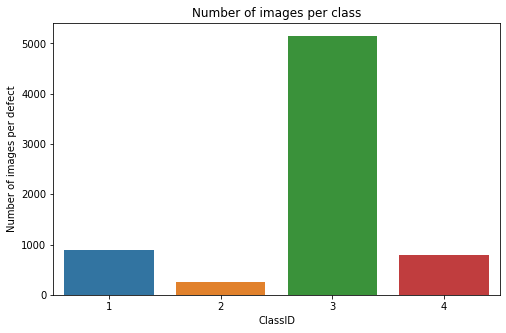

In [11]:
plt.figure(figsize=(8,5))
sns.countplot(data= defect_class_mask_df, x='ClassId')
plt.ylabel('Number of images per defect')
plt.xlabel('ClassID')
plt.title('Number of images per class')
plt.show()

The defect type 3 is over-represented vs the other types. This can penalize the classification performance during training.
- Class 3 represents 73% of the defects

In [12]:
defect_class_mask_df.groupby('ClassId').mask.count()/len(defect_class_mask_df)*100

ClassId
1    12.642706
2     3.481325
3    72.586328
4    11.289641
Name: mask, dtype: float64

In [13]:
defect_class_mask_df.groupby('ImageId').mask.count().sort_values(ascending=False)

ImageId
ef24da2ba.jpg    3
db4867ee8.jpg    3
84865746c.jpg    2
5665ada1b.jpg    2
eb44ad79d.jpg    2
                ..
59ce36e8a.jpg    1
59c00ad1f.jpg    1
59bcf1693.jpg    1
59bc9997f.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 6666, dtype: int64

In [14]:
# Some images are classified with more than one defect, let's explore this futher
# we have one image with 3 types of defects 
# we have 272 images with 2 types of defects
# we have 5201 images with 1 type of defect
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()

In [15]:
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 6666, dtype: int64

In [16]:
defect_type.value_counts()

1    6239
2     425
3       2
Name: mask, dtype: int64

Text(0.5, 1.0, 'Number of defects in image')

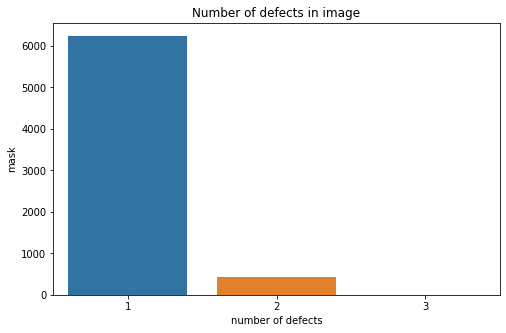

In [17]:
plt.figure(figsize=(8,5))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts() )
plt.xlabel('number of defects')
plt.title('Number of defects in image')

Most images have only 1 defect

In [18]:
defect_class_mask_df.shape

(7095, 4)

In [19]:
all_images_df.shape

(12997, 2)

In [20]:
# Let's count defective and non defective images
all_images_df.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

Text(0.5, 1.0, 'Defect and non-defect images')

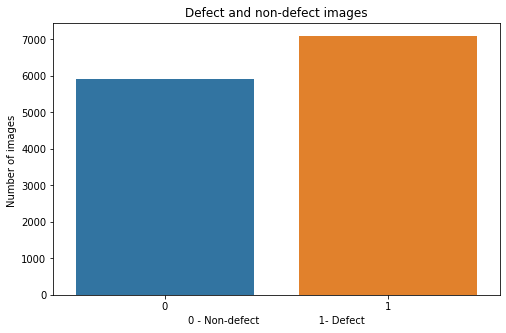

In [21]:
plt.figure(figsize=(8,5))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts() )
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect                   1- Defect')
plt.title('Defect and non-defect images')

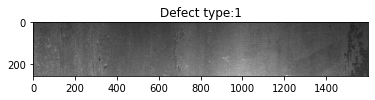

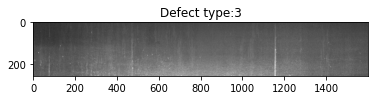

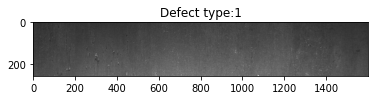

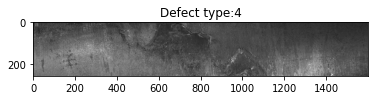

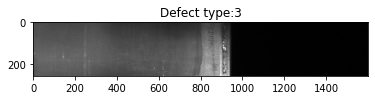

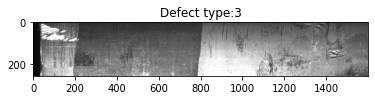

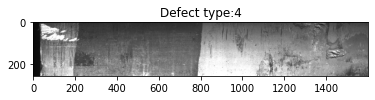

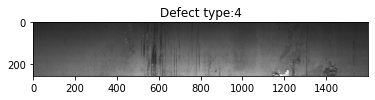

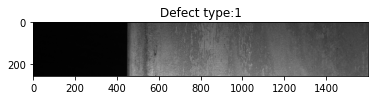

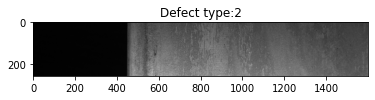

In [22]:
# Visualize images with defects along with their corresponding labels
# Images are 256 x 1600
#from google.colab.patches import cv2_imshow
train_dir = 'train_images/'

for i in range(10):
  # Specify the path to the images given their image ID
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  plt.figure()
  plt.title('Defect type:'+str(defect_class_mask_df.ClassId[i]))
  plt.imshow(img)


## Localize the defect : Image segmentation

In [23]:
from google.colab import files
files.upload() 

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Utilities file contains the code for rle2mask, mask2rle, custom loss function and custom data generator
# since the data provided for segmentation is in RLE format (run length encoded), we will be using the following function to convert the RLE to mask. 
# we can convert the mask back again to RLE to assess model performance (accuracy).
# Code source for these function came from: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
import sys
import os
#py_file_location = "/content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE/"
#sys.path.append(os.path.abspath(py_file_location))

#%cd /content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE
from utilities import rle2mask , mask2rle

train_dir = 'train_images/'

In [ ]:
defect_class_mask_df

In [ ]:
# Let's try to use the rle2mask on a sample image 
image_index = 20 #20 30
mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], img.shape[0], img.shape[1])
mask.shape

In [ ]:
# Let's show the mask
plt.imshow(mask)

In [ ]:
img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[image_index]))
plt.imshow(img)
img.shape

In [ ]:
for i in range(10):

  # Read the images using opencv and converting to rgb format
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Get the mask for the image from rle
  mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])
  
  # Let's color the pixels with values = 1 - We use the channel 1 or Green
  img[mask == 1,1] = 255
  plt.figure()
  plt.imshow(img)
  plt.title('Defect type: '+ str(defect_class_mask_df.ClassId[i]))


# BUILD AND TRAIN A DEEP LEARNING MODEL TO DETECT WHETHER A DEFECT IS PRESENT IN AN IMAGE OR NOT

In [24]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [25]:
# split the data (defective and non defective) into training and testing 
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size=0.15)

In [26]:
train.shape

(11047, 2)

In [27]:
test.shape

(1950, 2)

In [28]:
train_dir = 'train_images/'


In [29]:
# create a image generator for the training and validation dataset
# we will divide the data to training, validation and testing
# Training = 9390 
# validation = 1657 
# testing = 1950 

from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (299, 299))   # Input size required by ResNet model


valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (299, 299),)


Found 9390 validated image filenames.
Found 1657 validated image filenames.


In [30]:
# Create a data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (299, 299))



Found 1950 validated image filenames.


In [31]:
basemodel = ResNet50(weights = None, include_top = False, input_tensor = Input(shape=(256,256,3)))

In [39]:
basemodel.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [40]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## The typical transfer-learning workflow
- https://keras.io/guides/transfer_learning/

In [41]:
# freeze the model weights
for layer in basemodel.layers:
  layer.trainable = False

In [42]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)



In [44]:
basemodel = InceptionResNetV2(weights='imagenet', input_shape=(256,256,3), include_top=False)
#model.load_weights('/kaggle/input/inceptionresnetv2/inception_resent_v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
basemodel.trainable=False

x=basemodel.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dense(64,activation='relu')(x) 
out=Dense(1,activation='sigmoid')(x) #final layer binary classifier

model=Model(inputs=basemodel.input,outputs=out) 

In [45]:
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [46]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="inception-weights.hdf5", verbose=1, save_best_only=True)

In [47]:
# (WARNING TAKES LONG TIME (~90 mins)!)
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator, 
                              validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

C:\Users\Indra\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
586/586 [==============================] - 275s 439ms/step - loss: 0.4466 - accuracy: 0.7757 - val_loss: 0.2920 - val_accuracy: 0.8641

Epoch 00001: val_loss improved from inf to 0.29200, saving model to inception-weights.hdf5
Epoch 2/40
586/586 [==============================] - 254s 434ms/step - loss: 0.2695 - accuracy: 0.8836 - val_loss: 0.2519 - val_accuracy: 0.8932

Epoch 00002: val_loss improved from 0.29200 to 0.25186, saving model to inception-weights.hdf5
Epoch 3/40
586/586 [==============================] - 255s 434ms/step - loss: 0.2363 - accuracy: 0.8972 - val_loss: 0.2501 - val_accuracy: 0.9029

Epoch 00003: val_loss improved from 0.25186 to 0.25014, saving model to inception-weights.hdf5
Epoch 4/40
586/586 [==============================] - 254s 433ms/step - loss: 0.2137 - accuracy: 0.9045 - val_loss: 0.2131 - val_accuracy: 0.9126

Epoch 00004: val_loss improved from 0.25014 to 0.21306, saving model to inception-weights.hdf5
Epoch 5/40
586/586 [================

In [40]:
# save the trained model architecture for future use

model_json = model.to_json()
with open("inception-classifier-model.json","w") as json_file:
  json_file.write(model_json)

NameError: name 'model' is not defined

# ASSESS TRAINED MODEL PERFORMANCE

In [41]:
with open('inception-classifier-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('inception-weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [42]:
# Make prediction (WARNING TAKES LONG TIME (~10 mins)!)
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

121/121 [==============================] - 59s 352ms/step


In [43]:
test_predict

array([[9.5089865e-01],
       [9.5766747e-01],
       [5.0733653e-03],
       ...,
       [8.2989377e-01],
       [1.8003178e-04],
       [7.3928095e-02]], dtype=float32)

In [144]:
img = cv2.imread('test_images/0a2c9f2e5.jpg')

img = cv2.resize(img,(256,256))

img = np.reshape(img,[1,256,256,3])

classes = model.predict(img)

print(classes)


[[0.]]


In [44]:
# Since we have used sigmoid activation at the end, our result would contain continuous values from 0 to 1.
# The network is initially used to classify whether the image has defect or not
# Then these images (defective) is passed through the segmentation network to get the localization and type of defect. 
# Let's choose 0.01, to make sure, that we omit images from passing through the segmentation network only we are highly certain that it has no defect and if we are not confident, we can pass this image through the segmentation 
# network

predict = []

for i in test_predict:
  if i < 0.01: #0.5
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)

In [45]:
len(predict)

1936

In [46]:
# since we have used test generator, it limited the images to 1936, due to batch size
original = np.asarray(test.label)[:1936]
len(original)

1936

In [73]:
test.iloc[2][0]

'98111e480.jpg'

In [47]:
# Find the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.7701446280991735

<AxesSubplot:>

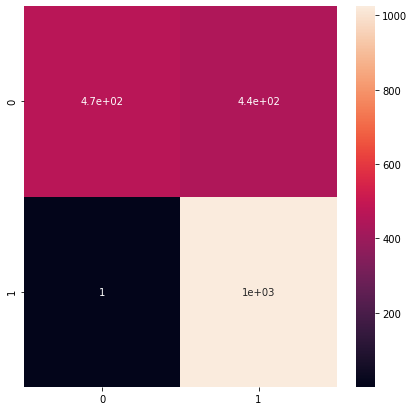

In [48]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [49]:
# Print the classification report

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       1.00      0.51      0.68       911
           1       0.70      1.00      0.82      1025

    accuracy                           0.77      1936
   macro avg       0.85      0.76      0.75      1936
weighted avg       0.84      0.77      0.75      1936



# BUILD A RES-U-NET SEGMENTATION MODEL

In [32]:
#spliting the data into train and test data
X_train, X_val = train_test_split(defect_class_mask_df, test_size=0.2)

In [33]:
#creating separate list for imageId, classId and rle to pass into the generator

train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
#train_class = [float(item) for item in train_class]
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
#val_class = [float(item) for item in val_class]
val_rle = list(X_val.EncodedPixels)

In [34]:
from utilities import DataGenerator

#creating image generators
training_generator = DataGenerator(train_ids,train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids,val_class,val_rle, train_dir)


In [35]:
def resblock(X, f):

  # making a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [36]:
# function to upscale and concatnating the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [37]:
input_shape = (256,256,1)

#Input tensor shape
X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#Stage 5
conv5_in = resblock(pool_4, 256)

#Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


## Loss function:
 
We need a custom loss function to train this ResUNet.So,  we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}

In [38]:
#%cd /content/drive/My Drive/Colab Notebooks/UDEMY_DATA_SCIENCE/MAINTENANCE/

from utilities import focal_tversky, tversky_loss, tversky

In [39]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])
model_seg.load_weights('resunet-segmentation-weights.hdf5')

In [40]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="resunet-segmentation-weights.hdf5", verbose=1, save_best_only=True)

In [41]:
history = model_seg.fit_generator(training_generator, epochs = 40, validation_data= validation_generator, callbacks=[checkpointer, earlystopping])

C:\Users\Indra\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
354/354 [==============================] - 890s 2s/step - loss: 0.7340 - tversky: 0.3360 - val_loss: 0.6856 - val_tversky: 0.3933

Epoch 00001: val_loss improved from inf to 0.68558, saving model to resunet-segmentation-weights.hdf5
Epoch 2/40
354/354 [==============================] - 230s 644ms/step - loss: 0.6497 - tversky: 0.4355 - val_loss: 0.6203 - val_tversky: 0.4683

Epoch 00002: val_loss improved from 0.68558 to 0.62027, saving model to resunet-segmentation-weights.hdf5
Epoch 3/40
354/354 [==============================] - 172s 485ms/step - loss: 0.6102 - tversky: 0.4803 - val_loss: 0.5848 - val_tversky: 0.5089

Epoch 00003: val_loss improved from 0.62027 to 0.58485, saving model to resunet-segmentation-weights.hdf5
Epoch 4/40
354/354 [==============================] - 180s 508ms/step - loss: 0.5857 - tversky: 0.5075 - val_loss: 0.6241 - val_tversky: 0.4647

Epoch 00004: val_loss did not improve from 0.58485
Epoch 5/40
354/354 [==============================] - 179s

354/354 [==============================] - 175s 494ms/step - loss: 0.3143 - tversky: 0.7840 - val_loss: 0.5223 - val_tversky: 0.5766

Epoch 00040: val_loss did not improve from 0.48665


In [42]:
# save the model for future use

model_json = model_seg.to_json()
with open("resunet-segmentation-model.json","w") as json_file:
  json_file.write(model_json)

# TASK #9: ASSESS TRAINED SEGMENTATION MODEL PERFORMANCE

In [43]:
from utilities import focal_tversky, tversky_loss, tversky

with open('resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model  
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [44]:
# data containing test images for segmentation task 
test_df = pd.read_csv('test.csv')

In [45]:
test_df

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,188383 3 188637 5 188892 6 189148 5 189403 6 1...
1,7773445b7.jpg,3,75789 33 76045 97 76300 135 76556 143 76811 15...
2,5e0744d4b.jpg,3,120323 91 120579 182 120835 181 121091 181 121...
3,6ccde604d.jpg,3,295905 32 296098 95 296290 159 296483 222 2967...
4,16aabaf79.jpg,1,352959 24 353211 28 353465 31 353719 33 353973...
...,...,...,...
633,a4334d7da.jpg,4,11829 7 12073 20 12317 32 12566 40 12821 41 13...
634,418e47222.jpg,3,46340 43 46596 127 46852 211 47108 253 47364 2...
635,817a545aa.jpg,3,206529 64 206657 4518 211201 179 211457 128 21...
636,caad490a5.jpg,3,59631 10 59867 30 60103 50 60339 69 60585 79 6...


In [46]:
from utilities import prediction

# make prediction
image_id, defect_type, mask = prediction(test_df, model, model_seg)

NameError: name 'model' is not defined

In [ ]:
# create a dataframe for the result
df_pred= pd.DataFrame({'ImageId': image_id,'EncodedPixels': mask,'ClassId': defect_type})
df_pred.head()

,ImageId,EncodedPixels,ClassId
0,0ca915b9f.jpg,151421 1 151423 2 151677 1 151679 2 151933 1 1...,3
1,7773445b7.jpg,72927 2 73183 2 73439 2 73695 2 73951 2 74207 ...,3
2,5e0744d4b.jpg,116095 2 116351 2 116607 2 116863 2 117119 2 1...,3
3,6ccde604d.jpg,290305 4 290561 4 290817 4 291073 4 291329 4 2...,3
4,16aabaf79.jpg,352937 24 353193 24 353449 24 353705 24 353961...,3


	Ground truth 					Prediction


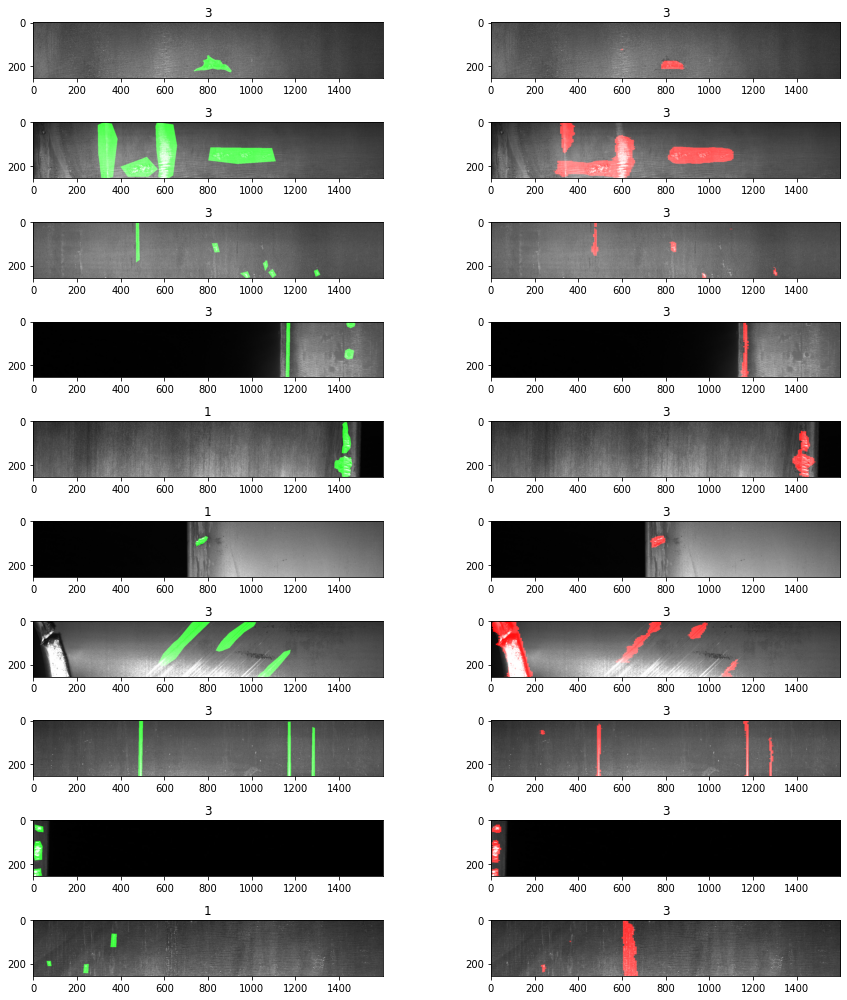

In [ ]:
# Let's show the images along with their original (ground truth) masks
directory = "train_images"
fig, axes = plt.subplots(10, 2, figsize = (14, 14))
axes = axes.ravel()    # convert 2D axes into 1D for below for loop
print('\tGround truth', '\t\t\t\t\tPrediction')
for i in range(10):

  # read the images using opencv and convert them to rgb format
  img = io.imread(os.path.join(train_dir,test_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # read the images using opencv and convert to rgb format
  pred_img = io.imread(os.path.join(directory,df_pred.ImageId[i]))
  pred_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Obtain mask for the image from rle
  mask = rle2mask(test_df.EncodedPixels[i],img.shape[0],img.shape[1])

  # get the mask for the image from rle
  mask_pred = rle2mask(df_pred.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,1] = 255
  pred_img[mask_pred == 1,0] = 255

  plt.title(test_df.ClassId[i])

  axes[2*i].set_title(test_df.ClassId[i])
  axes[2*i].imshow(img)
  axes[2*i+1].set_title(df_pred.ClassId[i])
  axes[2*i+1].imshow(pred_img)
  plt.tight_layout()
